In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("parulpandey/palmer-archipelago-antarctica-penguin-data")

print("Path to dataset files:", path)

/home/ikx/Desktop/NSU_courses/NSU_Statistic/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/ikx/.cache/kagglehub/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data/versions/1


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from tabulate import tabulate
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from itertools import combinations
import statsmodels.api as sm

In [5]:
df = pd.read_csv(path + '/penguins_size.csv')

In [6]:
def dataframe_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    """
    Выполняет очистку датасета от пропусков и некорректных значений.
    """
    df = df.dropna()
    df = df[df['sex'] != '.']
    return df

def dataset_report(df: pd.DataFrame, top_n: int = None):
    """
    Генерация сводной таблицы по датафрейму:
    - для числовых признаков: min, max, mean
    - для категориальных признаков: распределение (все или top_n значений)
    
    :param df: DataFrame для анализа
    :param top_n: ограничение на количество выводимых значений (например, top_n=5)
    """
    info = []
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            info.append([
                col,
                str(df[col].dtype),
                df[col].isna().sum(),
                round(df[col].isna().mean()*100, 2),
                df[col].nunique(),
                df[col].min(),
                df[col].max(),
                round(df[col].mean(), 2) if df[col].notna().any() else "-",
                "-"
            ])
        else:
            # распределение категориального признака
            vc = df[col].value_counts(dropna=False)
            if top_n is not None and len(vc) > top_n:
                top = vc.head(top_n)
                other_sum = vc.iloc[top_n:].sum()
                dist = dict(top)
                dist["Other"] = other_sum
            else:
                dist = dict(vc)
            dist_str = ", ".join([f"{k}: {v}" for k, v in dist.items()])
            info.append([
                col,
                str(df[col].dtype),
                df[col].isna().sum(),
                round(df[col].isna().mean()*100, 2),
                df[col].nunique(),
                "-",
                "-",
                "-",
                dist_str
            ])
    
    headers = [
        "Колонка", "Тип", "Пропуски", "% пропусков",
        "Уникальные", "Мин", "Макс", "Среднее", "Распределение"
    ]
    
    print("Размер датасета:", df.shape)
    print(tabulate(info, headers=headers, tablefmt="grid"))


def correlation_table(df, features):
    """
    Вычисляет коэффициенты корреляции Пирсона и Спирмена для всех пар числовых признаков
    и выводит таблицу через tabulate.
    
    Параметры:
    -----------
    df : DataFrame
        Таблица с данными
    features : list[str]
        Список числовых признаков
    """
    
    results = []

    for f1, f2 in combinations(features, 2):
        subset = df[[f1, f2]].dropna()
        x, y = subset[f1], subset[f2]

        # Пирсон
        r_p, p_p = pearsonr(x, y)
        # Спирмен
        r_s, p_s = spearmanr(x, y)

        results.append([
            f1,
            f2,
            round(r_p, 3),
            round(p_p, 5),
            round(r_s, 3),
            round(p_s, 5)
        ])

    # Таблица DataFrame
    corr_table = pd.DataFrame(results, columns=[
        "Признак 1", "Признак 2", "Пирсон r", "p-value (Пирсон)", "Спирмен ρ", "p-value (Спирмен)"
    ])

    # Вывод через tabulate
    print(tabulate(corr_table, headers='keys', tablefmt='grid', showindex=False))

    # return corr_table



In [7]:
def plot_pairwise(df, features, target, diag="hist", reg=False, predictive=False):
    """
    Визуализация по всем парам количественных признаков.
    
    Параметры:
    -----------
    df : DataFrame
    features : list[str] - количественные признаки
    target : str - категориальный признак (классы)
    diag : {"hist", "kde"}, default="hist"
    reg : bool, default=False - рисовать ли линии регрессии
    predictive : bool, default=False - если True, строятся 95% predictive intervals (по каждому классу)
    """
    
    marker_styles = ["o", "s", "D", "^", "v", "X", "P", "*", "H", "<", ">"]
    n_classes = df[target].nunique()
    markers = marker_styles[:n_classes]
    
    # если включили predictive → сами рисуем линии, поэтому kind="scatter"
    kind = "scatter" if (reg and predictive) else ("reg" if reg else "scatter")
    
    # аккуратно формируем plot_kws
    if reg and not predictive:
        plot_kws = {
            "scatter_kws": {"alpha": 0.6, "s": 40},
            "line_kws": {"lw": 2.5, "alpha": 0.9}
        }
    else:
        plot_kws = {"alpha": 0.6, "s": 40}
    
    # базовый pairplot
    g = sns.pairplot(
        df[features + [target]],
        hue=target,
        diag_kind=diag,
        kind=kind,
        markers=markers,
        diag_kws={"bins": 20, "edgecolor": "k"} if diag == "hist" else {},
        plot_kws=plot_kws
    )
    
    # если нужны predictive bands по классам
    if reg and predictive:
        classes = df[target].dropna().unique()
        palette = sns.color_palette(n_colors=len(classes))
        
        axes = g.axes
        n = len(features)
        
        for i in range(n):
            for j in range(n):
                if i == j:
                    continue
                ax = axes[j, i]  # seaborn convention
                f1, f2 = features[i], features[j]
                
                for c, color in zip(classes, palette):
                    subset = df[df[target] == c][[f1, f2]].dropna()
                    if subset.empty:
                        continue
                    
                    X = subset[f1]
                    y = subset[f2]
                    X_const = sm.add_constant(X)
                    model = sm.OLS(y, X_const).fit()
                    
                    x_pred = np.linspace(X.min(), X.max(), 200)
                    X_pred_const = sm.add_constant(x_pred)
                    pred = model.get_prediction(X_pred_const)
                    pred_summary = pred.summary_frame(alpha=0.05)
                    
                    ax.plot(x_pred, pred_summary["mean"], color=color, lw=2.5)
                    ax.fill_between(
                        x_pred,
                        pred_summary["obs_ci_lower"],
                        pred_summary["obs_ci_upper"],
                        color=color,
                        alpha=0.2
                    )
    
    plt.show()


def heatmap_corr(df_sub, features, title="Корреляционные матрицы"):
    """
    Строит 2 тепловые карты корреляций (Пирсон и Спирман) рядом.
    
    Параметры:
    -----------
    df_sub : DataFrame
        Датасет
    features : list[str]
        Список количественных признаков
    title : str
        Заголовок для всей фигуры
    """
    corr_pearson = df_sub[features].corr(method="pearson")
    corr_spearman = df_sub[features].corr(method="spearman")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap="coolwarm",
                vmin=-1, vmax=1, ax=axes[0])
    axes[0].set_title("Корреляция (Пирсон)")

    sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap="coolwarm",
                vmin=-1, vmax=1, ax=axes[1])
    axes[1].set_title("Корреляция (Спирман)")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()



In [25]:
def regression_summary(X, y):
    """
    Строит линейные регрессии вида y ~ X_i для каждого признака
    и выводит таблицу со статистиками (R², F, LR, Score).
    """
    results = []
    n = len(y)
    
    for col in X.columns:
        Xi = sm.add_constant(X[col])  # константа + один предиктор
        model = sm.OLS(y, Xi).fit()
        
        # Формула
        intercept = model.params['const']
        slope = model.params[col]
        equation = f"y = {intercept:.3f} + {slope:.3f}*{col}"
        
        # R²
        r2 = model.rsquared
        
        # F-тест (Вальда)
        f_stat = model.fvalue
        f_pval = model.f_pvalue
        df_model = int(model.df_model)
        df_resid = int(model.df_resid)
        
        # LR-тест (сравнение с моделью-константой, индексы выровнены!)
        null_model = sm.OLS(y, sm.add_constant(pd.DataFrame({"const": 1}, index=y.index))).fit()
        lr_stat, lr_pval, lr_df = model.compare_lr_test(null_model)
        
        # Score-тест (LM): регрессия остатков ограниченной модели на X[col]
        resid = null_model.resid
        aux_model = sm.OLS(resid, sm.add_constant(X[col])).fit()
        r2_aux = aux_model.rsquared
        lm_stat = n * r2_aux
        from scipy import stats
        lm_pval = 1 - stats.chi2.cdf(lm_stat, df=1)
        
        results.append([
            col,
            equation,
            round(r2, 4),
            f"F={f_stat:.3f}, df=({df_model},{df_resid}), p={f_pval:.4g}",
            f"LR={lr_stat:.3f}, df={int(lr_df)}, p={lr_pval:.4g}",
            f"Score={lm_stat:.3f}, df=1, p={lm_pval:.4g}"
        ])
    
    headers = ["Признак", "Формула", "R²", "Вальд (F)", "LR тест", "Score тест"]
    print(tabulate(results, headers=headers, tablefmt="grid"))


In [9]:
"""
Статистика по исходному датасету
"""
dataset_report(df)

Размер датасета: (344, 7)
+-------------------+---------+------------+---------------+--------------+--------+--------+-----------+-----------------------------------------+
| Колонка           | Тип     |   Пропуски |   % пропусков |   Уникальные | Мин    | Макс   | Среднее   | Распределение                           |
+===================+=========+============+===============+==============+========+========+===========+=========================================+
| species           | object  |          0 |          0    |            3 | -      | -      | -         | Adelie: 152, Gentoo: 124, Chinstrap: 68 |
+-------------------+---------+------------+---------------+--------------+--------+--------+-----------+-----------------------------------------+
| island            | object  |          0 |          0    |            3 | -      | -      | -         | Biscoe: 168, Dream: 124, Torgersen: 52  |
+-------------------+---------+------------+---------------+--------------+--------+--

In [10]:
"""
Статистика по чистому датасету
"""
df = dataframe_cleaning(df)
dataset_report(df)

Размер датасета: (333, 7)
+-------------------+---------+------------+---------------+--------------+--------+--------+-----------+-----------------------------------------+
| Колонка           | Тип     |   Пропуски |   % пропусков |   Уникальные | Мин    | Макс   | Среднее   | Распределение                           |
+===================+=========+============+===============+==============+========+========+===========+=========================================+
| species           | object  |          0 |             0 |            3 | -      | -      | -         | Adelie: 146, Gentoo: 119, Chinstrap: 68 |
+-------------------+---------+------------+---------------+--------------+--------+--------+-----------+-----------------------------------------+
| island            | object  |          0 |             0 |            3 | -      | -      | -         | Biscoe: 163, Dream: 123, Torgersen: 47  |
+-------------------+---------+------------+---------------+--------------+--------+--

## 🔹Попарная визуализация признаков по классам

### класс: **species**

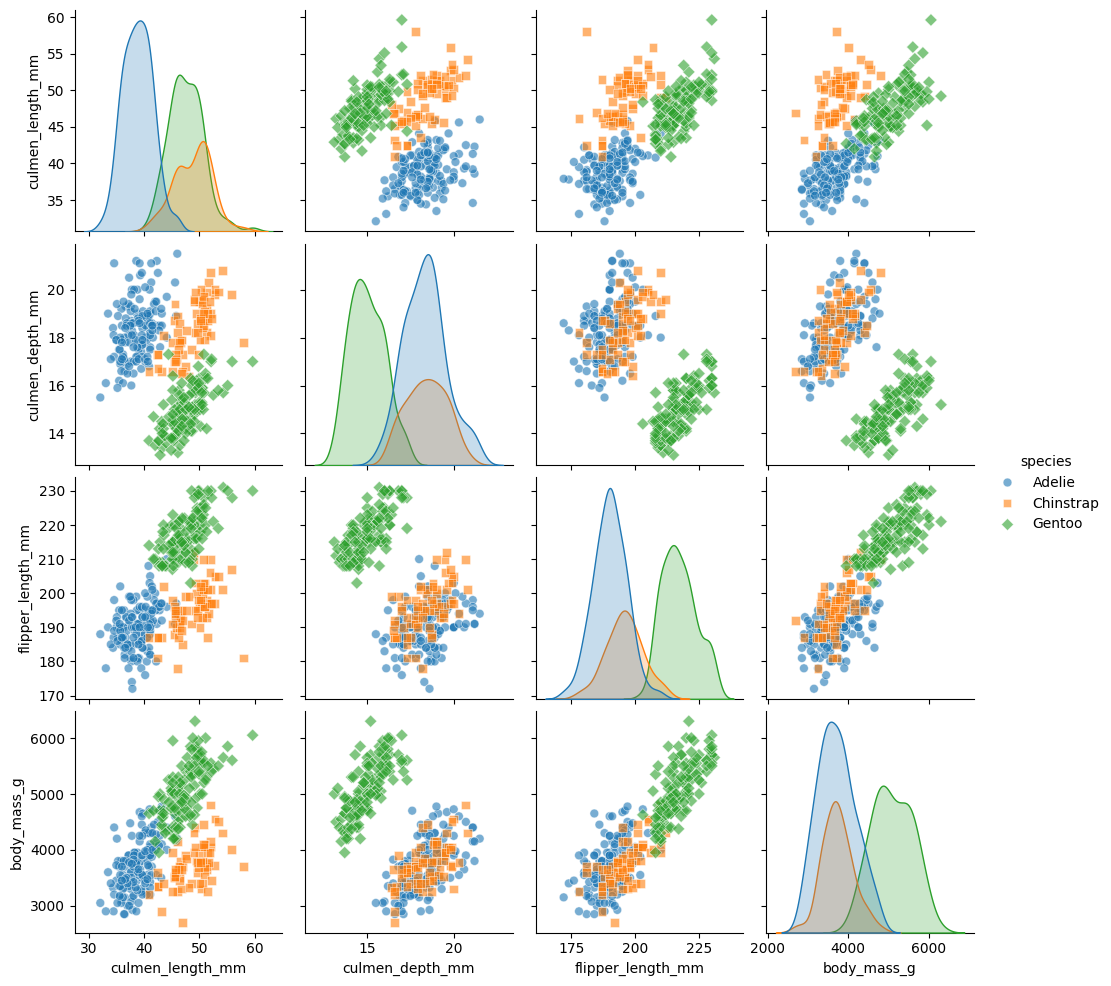

### класс: **island**

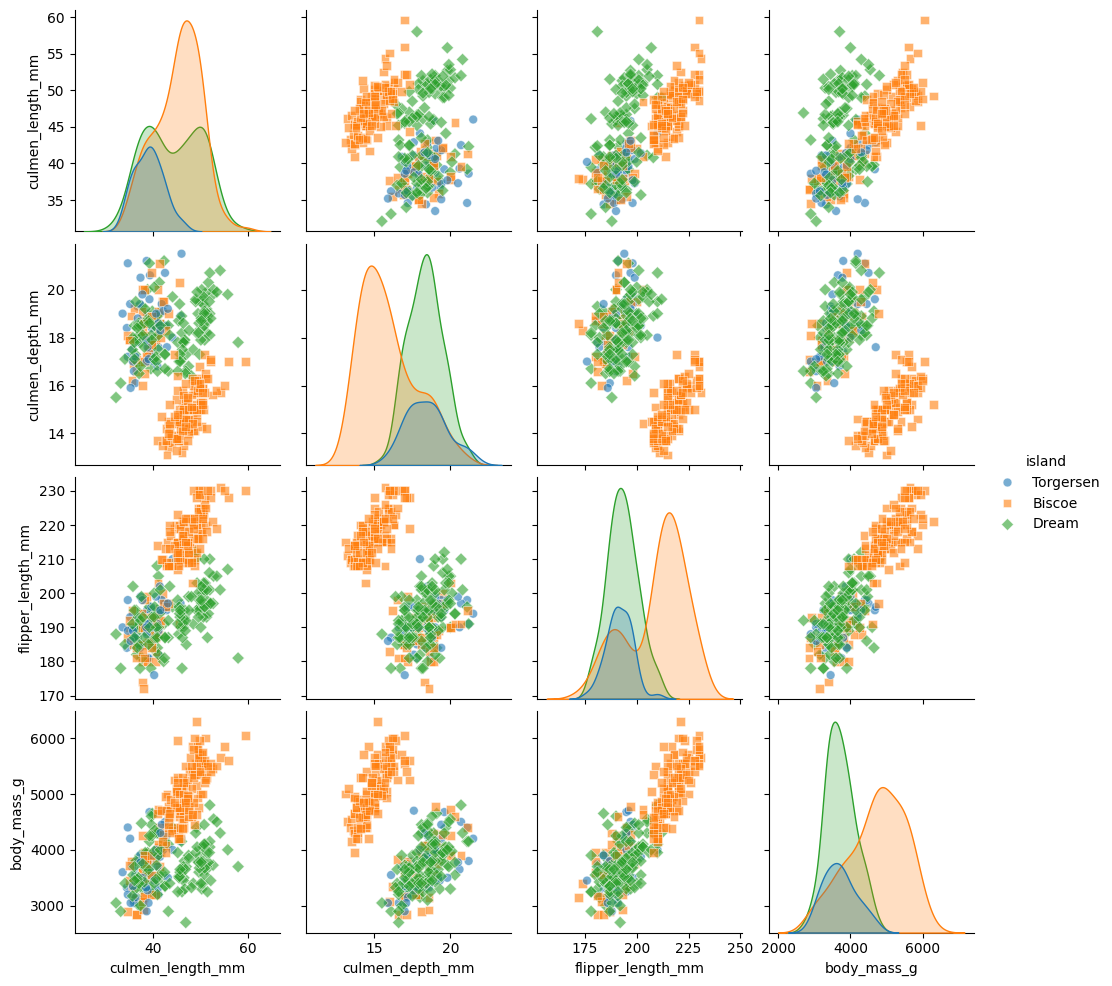

### класс: **sex**

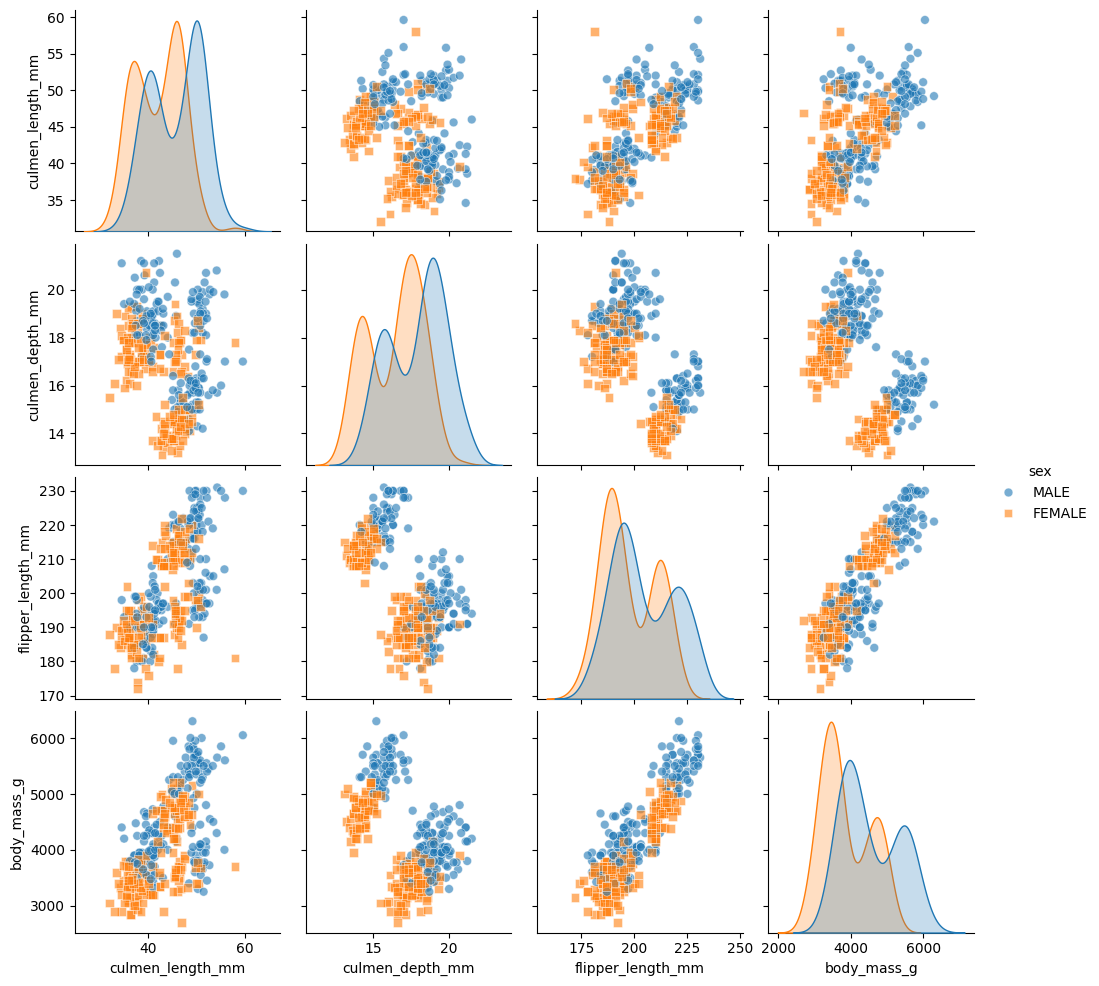

In [11]:
"""
Попарная визуализация количественных признаков для каждого таргета
"""

features = ["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g"]
targets = ["species", "island", "sex"]

display(Markdown(f"## 🔹Попарная визуализация признаков по классам"))
for target in targets:
    display(Markdown(f"### класс: **{target}**"))
    plot_pairwise(df, features, target, diag="kde")


## 🔹Корреляция на всем датасете

+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| Признак 1         | Признак 2         |   Пирсон r |   p-value (Пирсон) |   Спирмен ρ |   p-value (Спирмен) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |     -0.229 |              3e-05 |      -0.214 |               8e-05 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.653 |              0     |       0.67  |               0     |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.589 |              0     |       0.576 |               0     |
+-------------------+-------------------+------------+--------------------+-------------+---------------

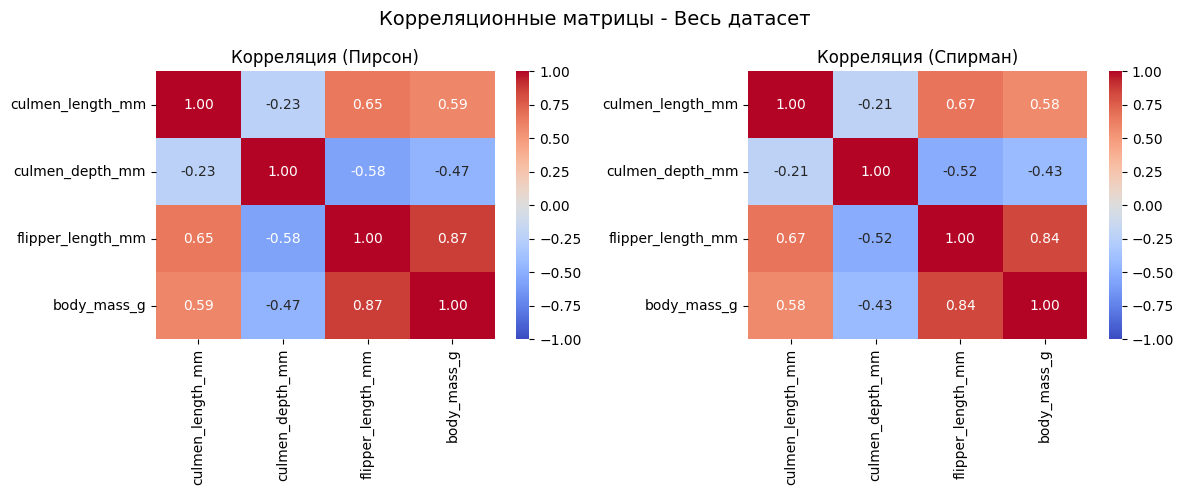

In [12]:
display(Markdown("## 🔹Корреляция на всем датасете"))
correlation_table(df, features)
heatmap_corr(df, features, title="Корреляционные матрицы - Весь датасет")

## 🔹Корреляция по признаку: **species**

### для объектов: **Adelie**

+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| Признак 1         | Признак 2         |   Пирсон r |   p-value (Пирсон) |   Спирмен ρ |   p-value (Спирмен) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |      0.386 |            0       |       0.355 |               1e-05 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.332 |            4e-05   |       0.348 |               2e-05 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.544 |            0       |       0.544 |               0     |
+-------------------+-------------------+------------+--------------------+-------------+---------------

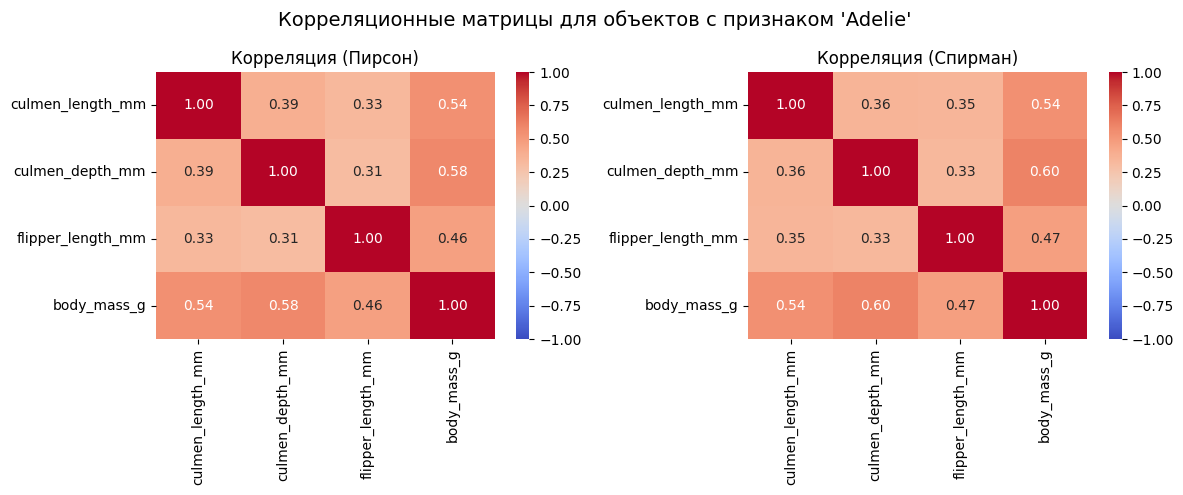

### для объектов: **Chinstrap**

+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| Признак 1         | Признак 2         |   Пирсон r |   p-value (Пирсон) |   Спирмен ρ |   p-value (Спирмен) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |      0.654 |              0     |       0.672 |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.472 |              5e-05 |       0.533 |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.514 |              1e-05 |       0.525 |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------

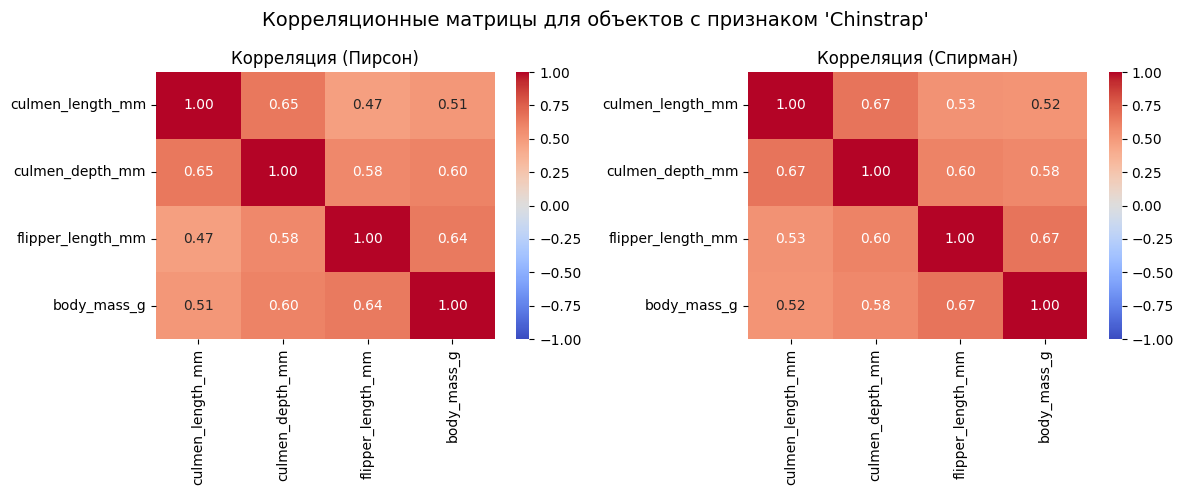

### для объектов: **Gentoo**

+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| Признак 1         | Признак 2         |   Пирсон r |   p-value (Пирсон) |   Спирмен ρ |   p-value (Спирмен) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |      0.654 |                  0 |       0.652 |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.664 |                  0 |       0.659 |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.667 |                  0 |       0.684 |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------

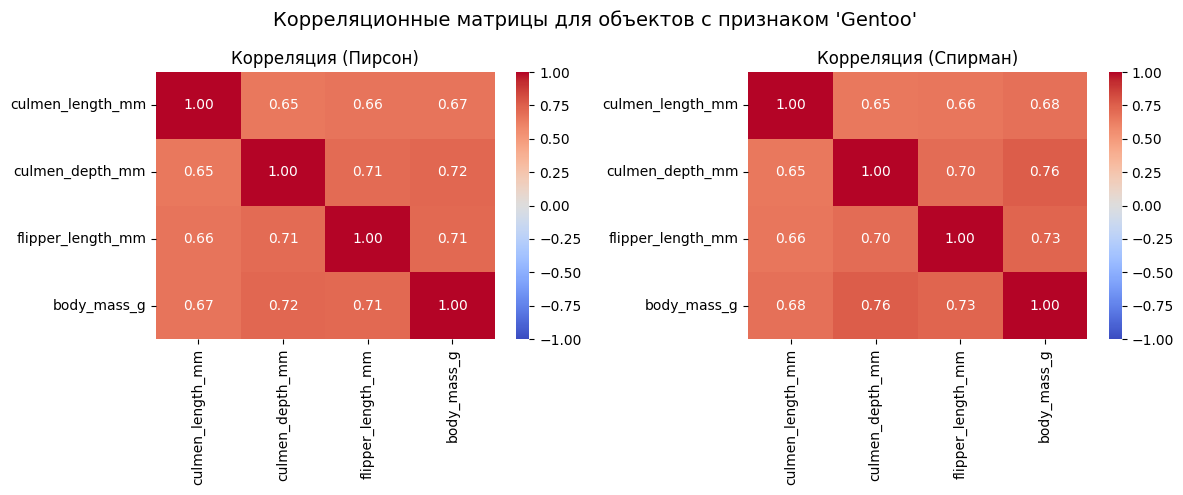

## 🔹Корреляция по признаку: **island**

### для объектов: **Torgersen**

+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| Признак 1         | Признак 2         |   Пирсон r |   p-value (Пирсон) |   Спирмен ρ |   p-value (Спирмен) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |      0.216 |            0.14461 |       0.187 |             0.20797 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.41  |            0.00417 |       0.444 |             0.00176 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.426 |            0.0028  |       0.437 |             0.00215 |
+-------------------+-------------------+------------+--------------------+-------------+---------------

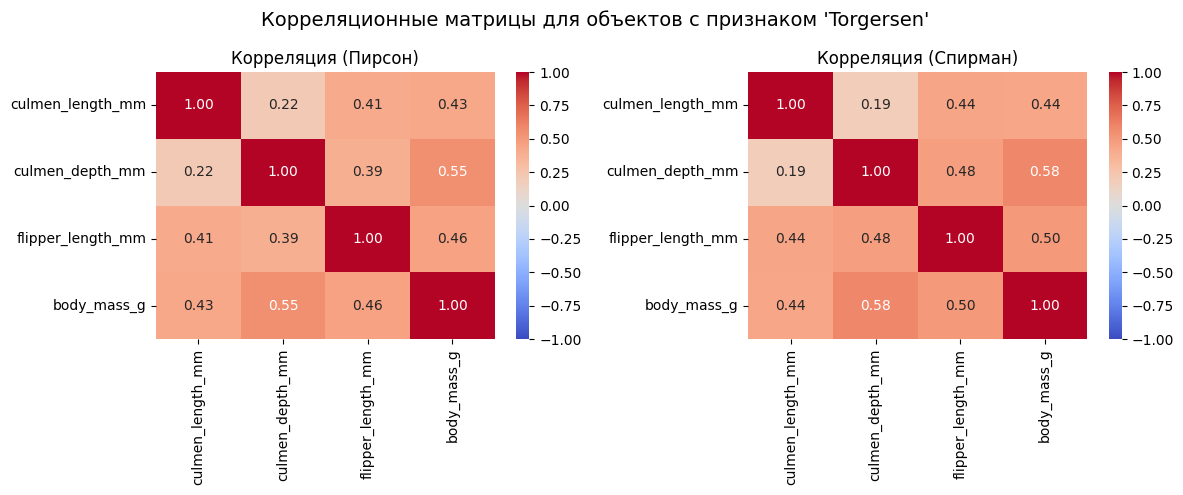

### для объектов: **Biscoe**

+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| Признак 1         | Признак 2         |   Пирсон r |   p-value (Пирсон) |   Спирмен ρ |   p-value (Спирмен) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |     -0.445 |                  0 |      -0.284 |             0.00024 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.868 |                  0 |       0.848 |             0       |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.87  |                  0 |       0.856 |             0       |
+-------------------+-------------------+------------+--------------------+-------------+---------------

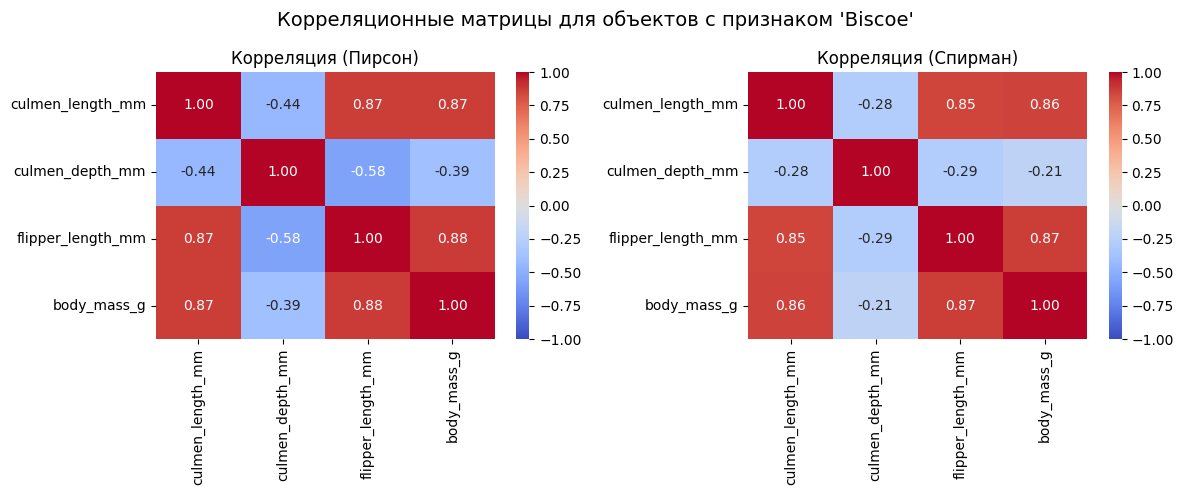

### для объектов: **Dream**

+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| Признак 1         | Признак 2         |   Пирсон r |   p-value (Пирсон) |   Спирмен ρ |   p-value (Спирмен) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |      0.365 |            3e-05   |       0.38  |             1e-05   |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.526 |            0       |       0.558 |             0       |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.3   |            0.00075 |       0.337 |             0.00014 |
+-------------------+-------------------+------------+--------------------+-------------+---------------

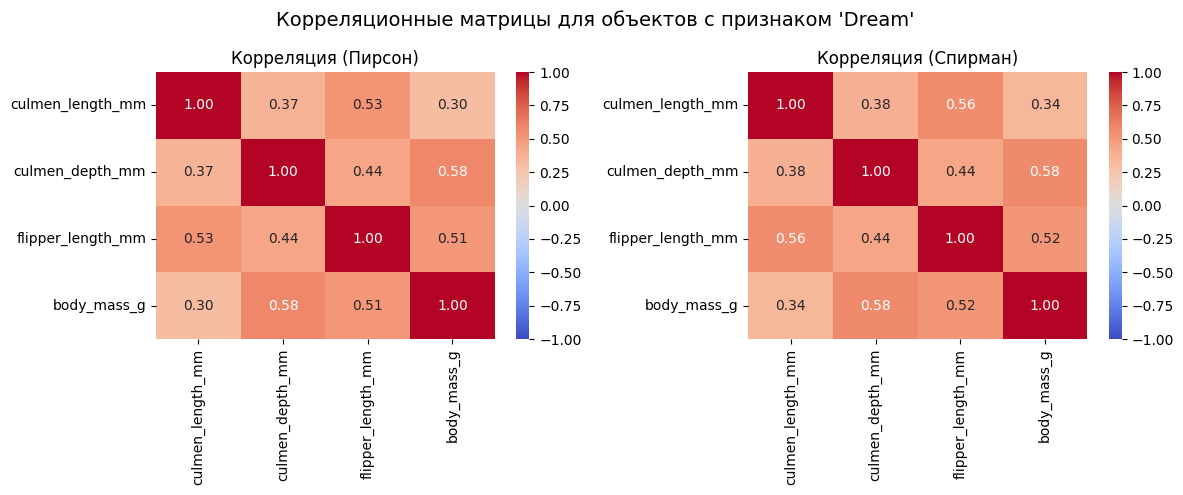

## 🔹Корреляция по признаку: **sex**

### для объектов: **MALE**

+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| Признак 1         | Признак 2         |   Пирсон r |   p-value (Пирсон) |   Спирмен ρ |   p-value (Спирмен) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |     -0.395 |                  0 |      -0.277 |             0.00027 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.663 |                  0 |       0.641 |             0       |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.477 |                  0 |       0.383 |             0       |
+-------------------+-------------------+------------+--------------------+-------------+---------------

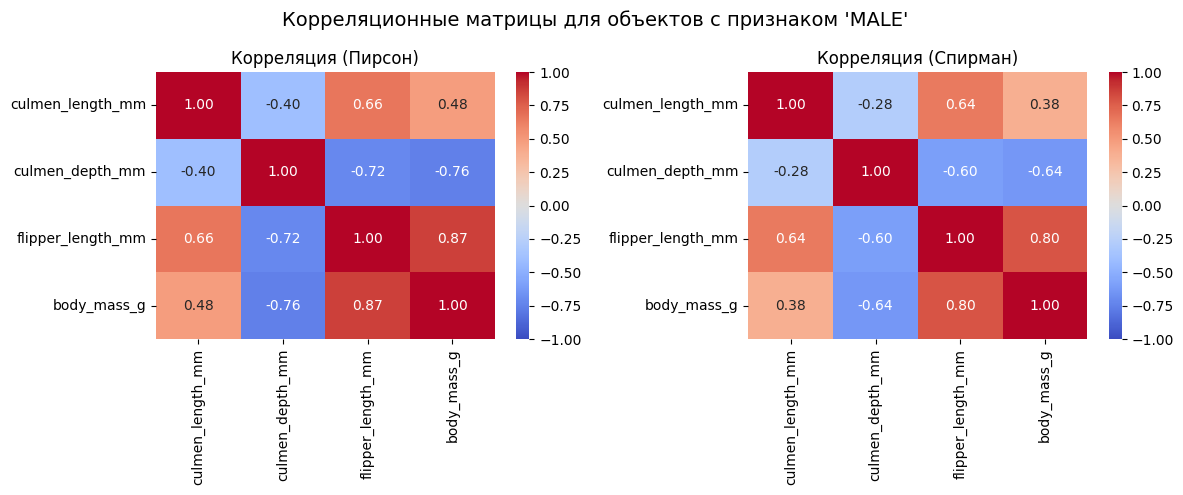

### для объектов: **FEMALE**

+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| Признак 1         | Признак 2         |   Пирсон r |   p-value (Пирсон) |   Спирмен ρ |   p-value (Спирмен) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |     -0.426 |                  0 |      -0.37  |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.571 |                  0 |       0.585 |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.581 |                  0 |       0.575 |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------

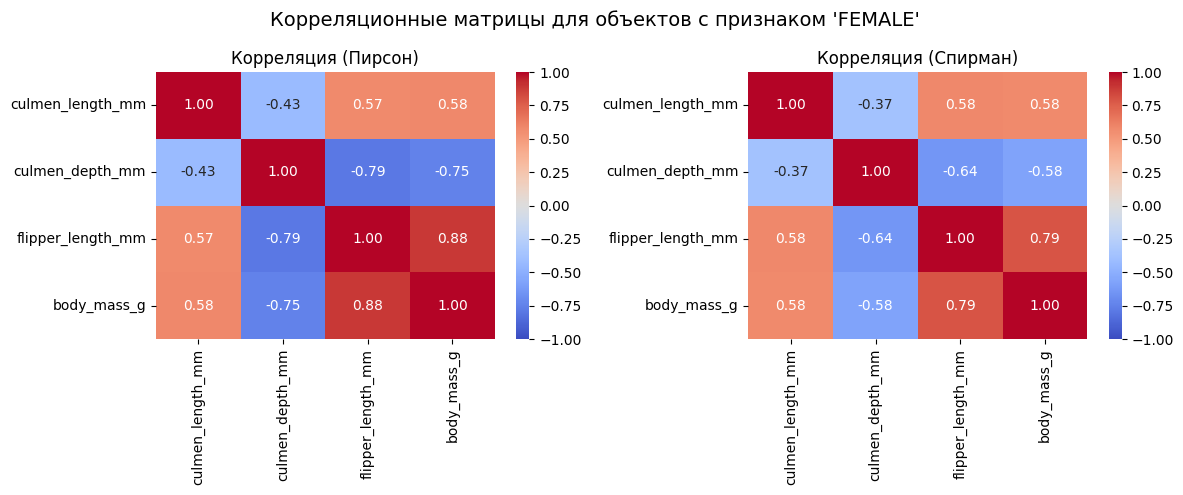

In [13]:
for target in targets:
    display(Markdown(f"## 🔹Корреляция по признаку: **{target}**"))

    for cls in df[target].dropna().unique():
        display(Markdown(f"### для объектов: **{cls}**"))
        
        # Таблица корреляций
        correlation_table(df[df[target] == cls], features)
        
        # Тепловая карта
        heatmap_corr(
            df[df[target] == cls],
            features,
            title=f"Корреляционные матрицы для объектов с признаком '{cls}'"
        )

## 🔹Попарные графики с регрессией и прогнозными интервалами

### класс: **species**

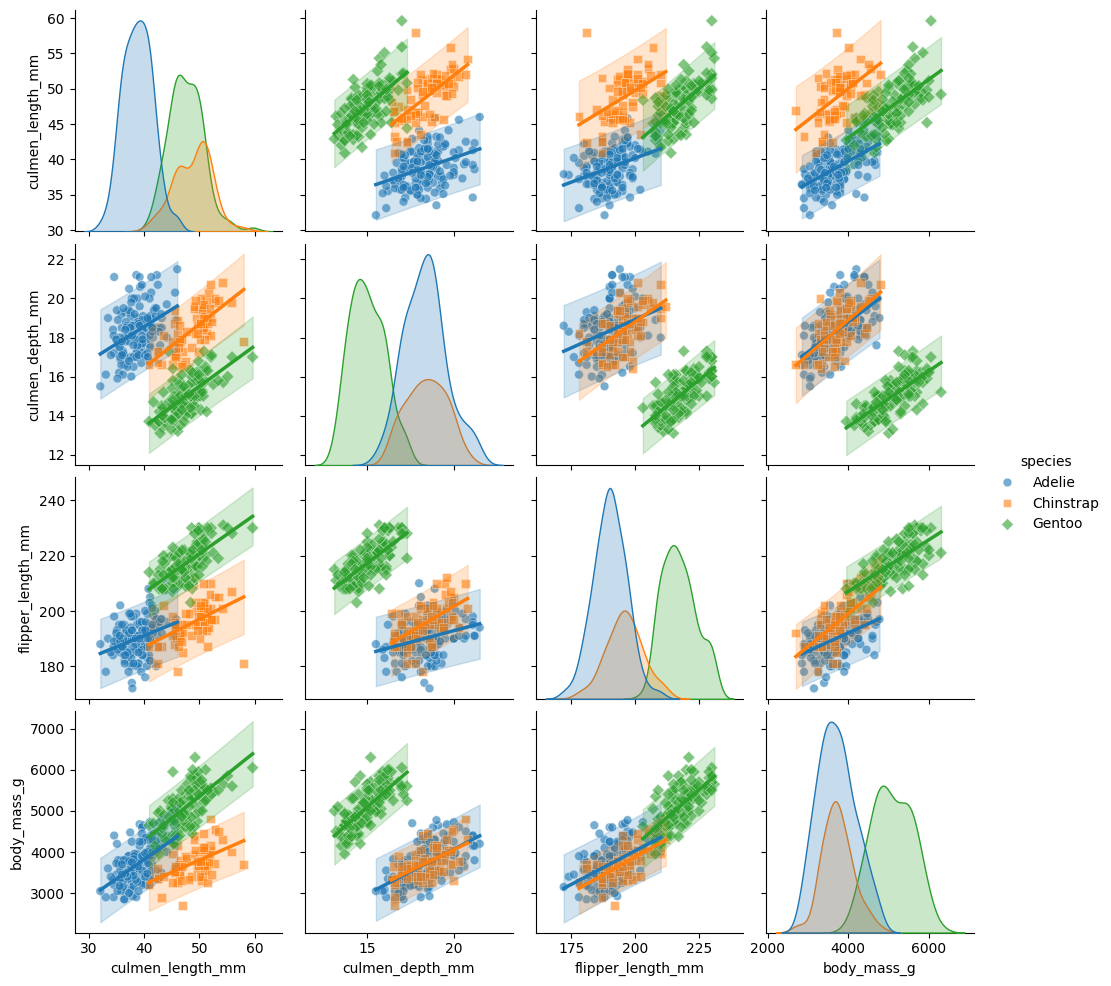

### класс: **island**

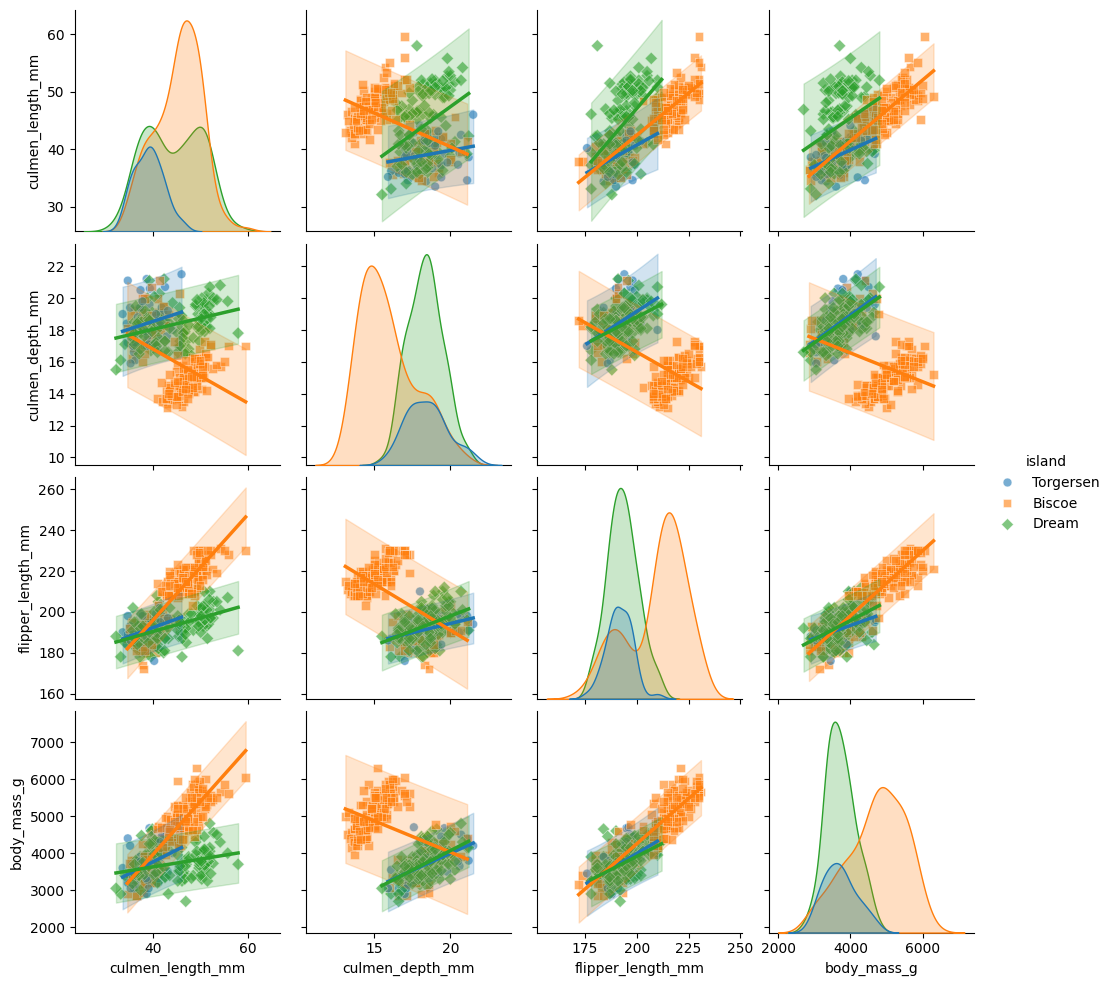

### класс: **sex**

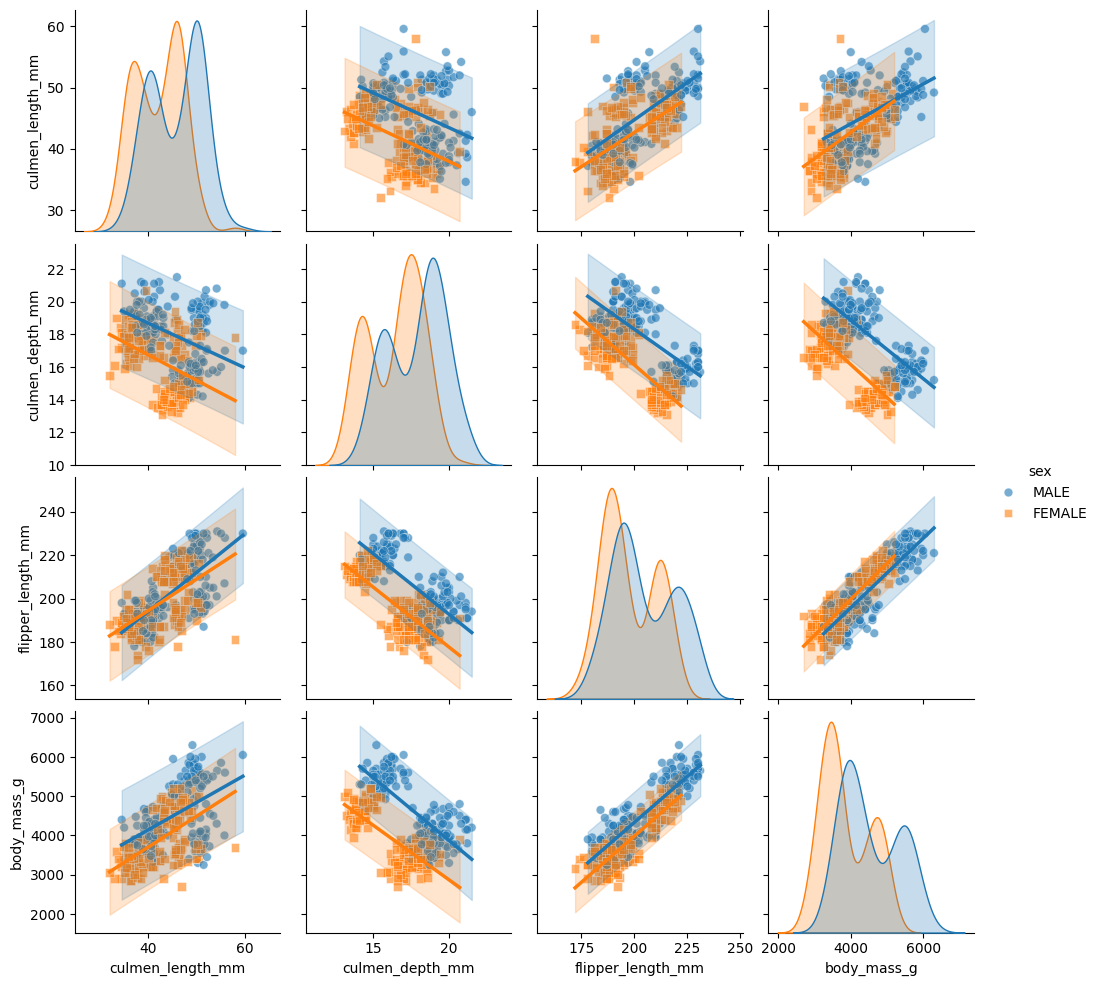

In [14]:
display(Markdown("## 🔹Попарные графики с регрессией и прогнозными интервалами"))
for target in targets:
    display(Markdown(f"### класс: **{target}**"))
    plot_pairwise(df, target=target, features=features, reg=True, predictive=True, diag="kde")

## 🔹Попарные графики с регрессией и доверительными интервалами

### класс: **species**

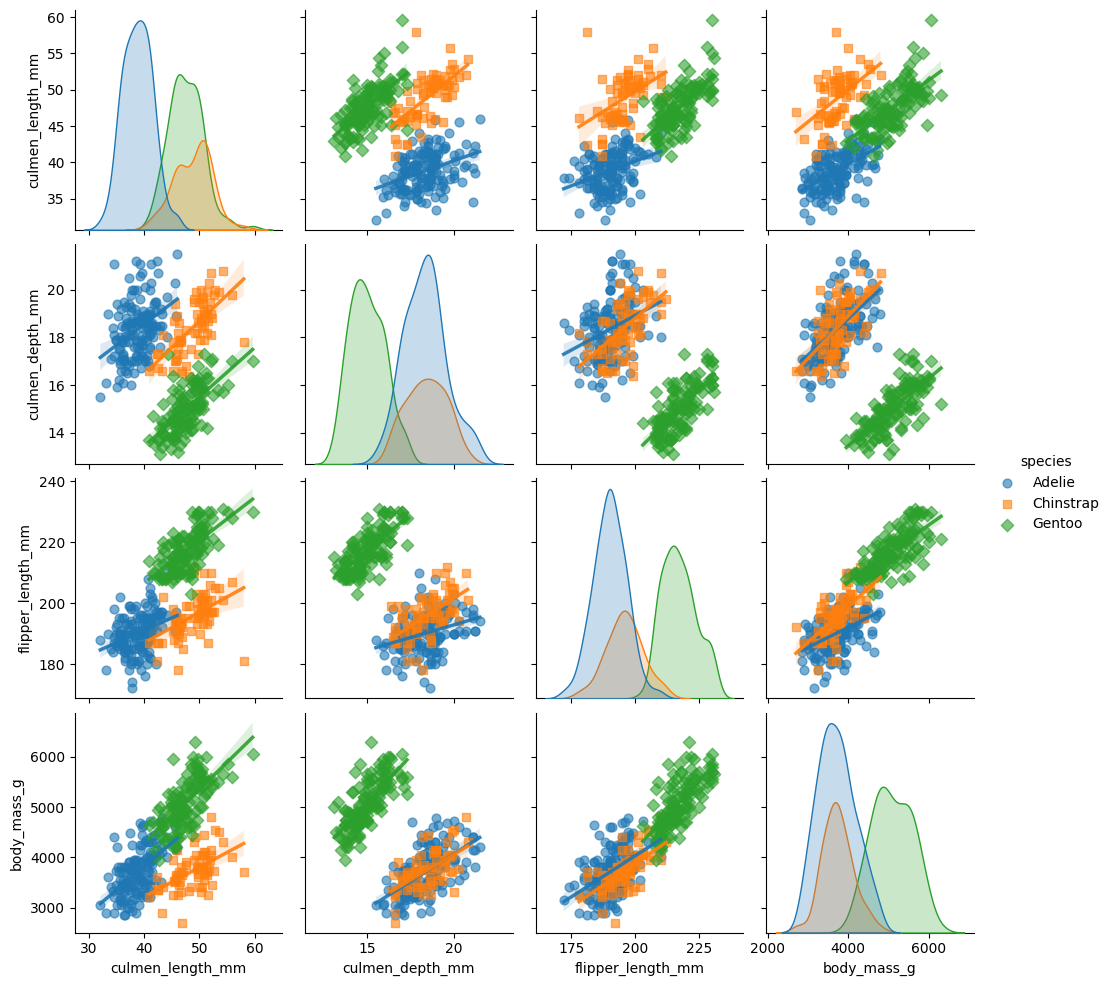

### класс: **island**

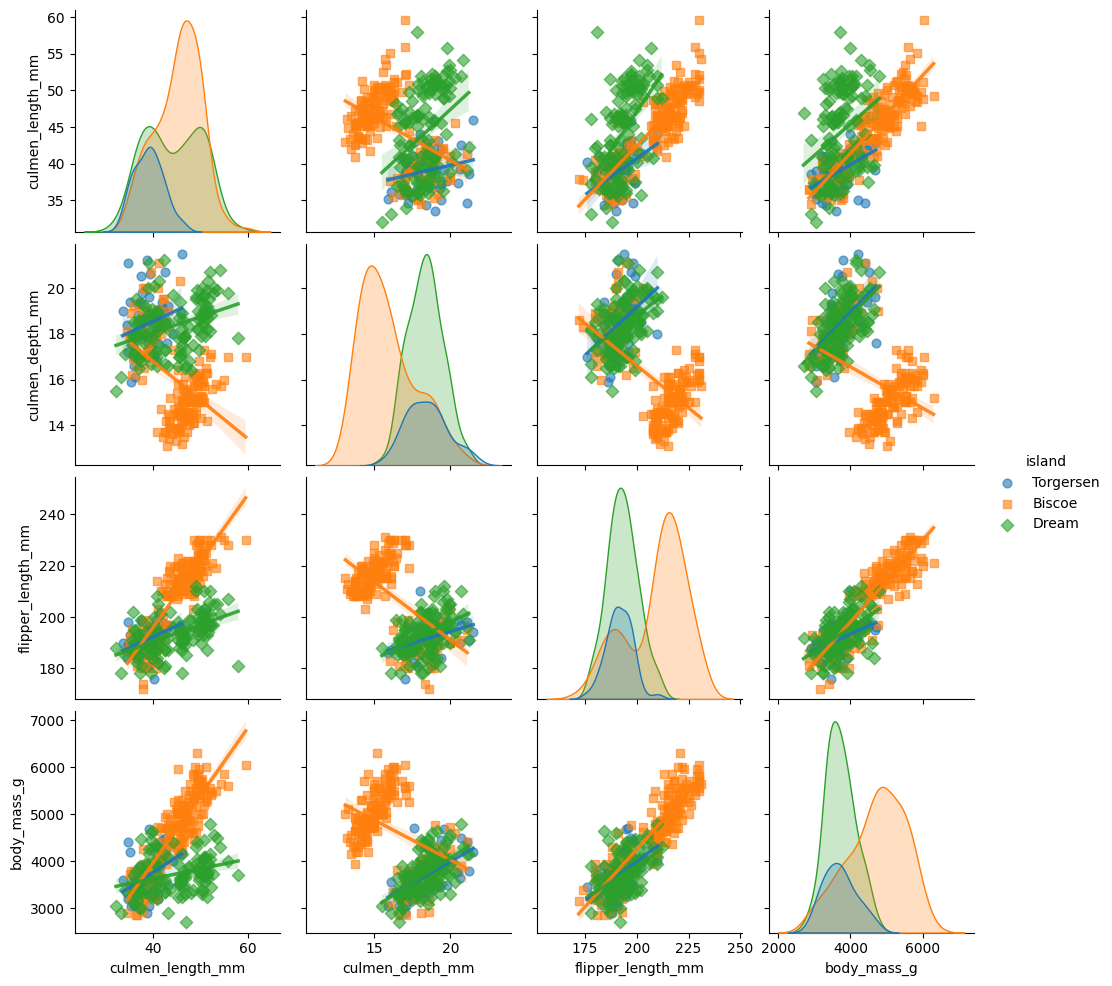

### класс: **sex**

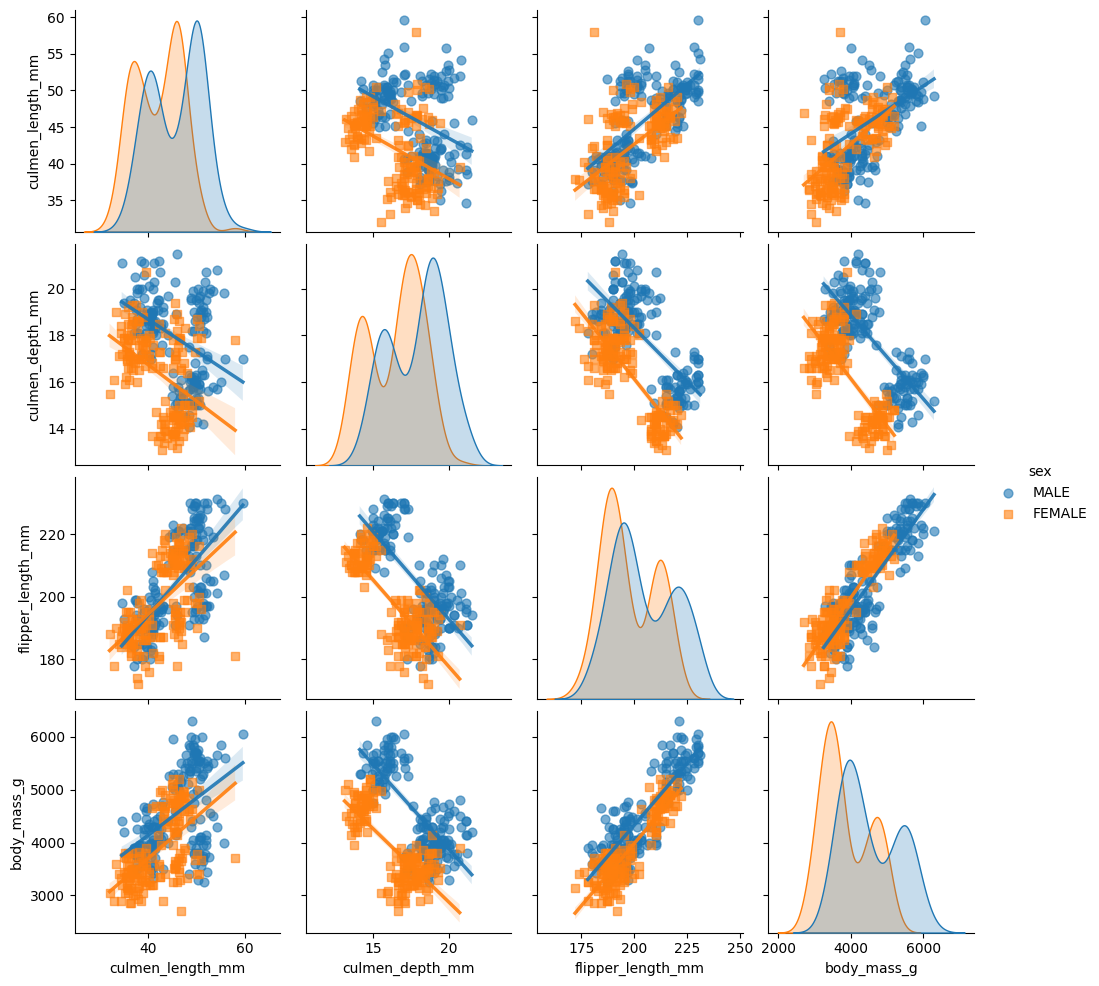

In [15]:
display(Markdown("## 🔹Попарные графики с регрессией и доверительными интервалами"))
for target in targets:
    display(Markdown(f"### класс: **{target}**"))
    plot_pairwise(df, features, target=target, reg=True, diag="kde")

In [36]:
for feature in features:
    display(Markdown(f"### Регрессии для признака: **{feature}**"))
    regression_summary(df[features], df[feature])

### Регрессии для признака: **culmen_length_mm**

+-------------------+--------------------------------------+--------+---------------------------------------------------------+-------------------------------+---------------------------------+
| Признак           | Формула                              |     R² | Вальд (F)                                               | LR тест                       | Score тест                      |
+===================+======================================+========+=========================================================+===============================+=================================+
| culmen_length_mm  | y = 0.000 + 1.000*culmen_length_mm   | 1      | F=47273189052264679639082961207296.000, df=(1,331), p=0 | LR=22354.749, df=1, p=0       | Score=333.000, df=1, p=0        |
+-------------------+--------------------------------------+--------+---------------------------------------------------------+-------------------------------+---------------------------------+
| culmen_depth_mm   | y = 54.8

### Регрессии для признака: **culmen_depth_mm**

+-------------------+---------------------------------------+--------+-------------------------------------------------------+-------------------------------+---------------------------------+
| Признак           | Формула                               |     R² | Вальд (F)                                             | LR тест                       | Score тест                      |
+===================+=======================================+========+=======================================================+===============================+=================================+
| culmen_length_mm  | y = 20.787 + -0.082*culmen_length_mm  | 0.0523 | F=18.255, df=(1,331), p=2.528e-05                     | LR=17.877, df=1, p=2.356e-05  | Score=17.406, df=1, p=3.019e-05 |
+-------------------+---------------------------------------+--------+-------------------------------------------------------+-------------------------------+---------------------------------+
| culmen_depth_mm   | y = 0.000 + 1

### Регрессии для признака: **flipper_length_mm**

+-------------------+--------------------------------------+--------+-------------------------------------------------------+--------------------------------+--------------------------+
| Признак           | Формула                              |     R² | Вальд (F)                                             | LR тест                        | Score тест               |
+===================+======================================+========+=======================================================+================================+==========================+
| culmen_length_mm  | y = 127.330 + 1.674*culmen_length_mm | 0.4265 | F=246.192, df=(1,331), p=7.211e-42                    | LR=185.167, df=1, p=3.609e-42  | Score=142.036, df=1, p=0 |
+-------------------+--------------------------------------+--------+-------------------------------------------------------+--------------------------------+--------------------------+
| culmen_depth_mm   | y = 271.555 + -4.112*culmen_depth_mm | 0.3338 | 

### Регрессии для признака: **body_mass_g**

+-------------------+------------------------------------------+--------+---------------------------------------------------------+--------------------------------+--------------------------+
| Признак           | Формула                                  |     R² | Вальд (F)                                               | LR тест                        | Score тест               |
+===================+==========================================+========+=========================================================+================================+==========================+
| culmen_length_mm  | y = 388.845 + 86.792*culmen_length_mm    | 0.3475 | F=176.243, df=(1,331), p=1.539e-32                      | LR=142.148, df=1, p=9.026e-33  | Score=115.702, df=1, p=0 |
+-------------------+------------------------------------------+--------+---------------------------------------------------------+--------------------------------+--------------------------+
| culmen_depth_mm   | y = 7519.981 + -19